In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil

In [ ]:
training_folder_name = '/content/drive/MyDrive/new res'

# All images are 128x128 pixels
img_size = (128,128)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

['0.0.Normal', '0.1.Tessellated fundus']


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.13.1+cu116


In [ ]:
from PIL import Image

# function to resize image
def resize_image(src_image, size=(128,128), bg_color="white"):
    from PIL import Image, ImageOps

    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)

    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)

    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))

    # return the resized image
    return new_image

In [ ]:
training_folder_name = '/content/drive/MyDrive/new res'

# New location for the resized images
train_folder = '/content/drive/MyDrive/working'


# Create resized copies of all of the source images
size = (128,128)

# Create the output folder if it doesn't already exist
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

# Loop through each subfolder in the input folder
print('Transforming images...')
for root, folders, files in os.walk(training_folder_name):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        # Create a matching subfolder in the output dir
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the files in the subfolder
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
            # Open the file
            file_path = os.path.join(root,sub_folder, file_name)
            #print("reading " + file_path)
            image = Image.open(file_path)
            # Create a resized version and save it
            resized_image = resize_image(image, size)
            saveAs = os.path.join(saveFolder, file_name)
            #print("writing " + saveAs)
            resized_image.save(saveAs)

print('Done.')

Transforming images...
processing folder 0.1.Tessellated fundus
processing folder 0.0.Normal
Done.


In [ ]:
def load_dataset(data_path):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )


    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size

    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )

    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )

    return train_loader, test_loader




#####################################################################################################




# Recall that we have resized the images and saved them into
train_folder = '/content/drive/MyDrive/working'

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Data loaders ready to read /content/drive/MyDrive/working


In [ ]:

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((32, 32))
        self.classifier = nn.Sequential(
            nn.Linear(32 * 32 * 24, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))

    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [ ]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # return average loss for the epoch
    return avg_loss

In [ ]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1


RuntimeError: ignored

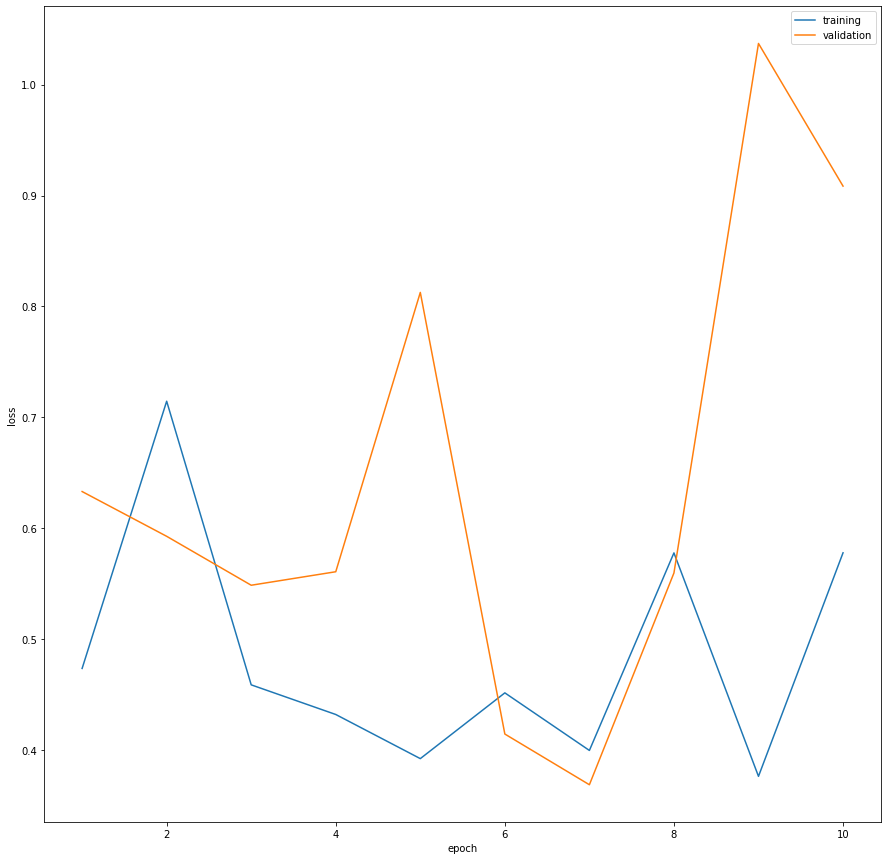

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...


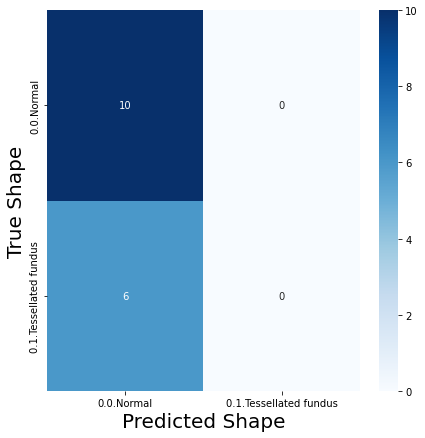

In [ ]:
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction)

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()